In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")
sns.set_context("talk")

In [3]:
from src.load_data import (
    _get_pos_dataframe,
    make_track_graph,
    classify_track_segments,
    calculate_linear_distance,
    calculate_linear_velocity,
    _calulcate_linear_position,
    EDGE_ORDER,
    EDGE_SPACING,
)


def get_position_dataframe(
    epoch_key,
    animals,
    route_euclidean_distance_scaling=1,
    sensor_std_dev=5,
    diagonal_bias=0.5,
    edge_spacing=EDGE_SPACING,
    edge_order=EDGE_ORDER,
):
    position_info = _get_pos_dataframe(epoch_key, animals)

    track_graph, center_well_id = make_track_graph()
    position = position_info.loc[:, ["x_position", "y_position"]].values

    track_segment_id = classify_track_segments(
        track_graph,
        position,
        route_euclidean_distance_scaling=route_euclidean_distance_scaling,
        sensor_std_dev=sensor_std_dev,
        diagonal_bias=diagonal_bias,
    )
    (
        position_info["linear_distance"],
        position_info["projected_x_position"],
        position_info["projected_y_position"],
    ) = calculate_linear_distance(
        track_graph, track_segment_id, center_well_id, position
    )
    position_info["track_segment_id"] = track_segment_id
    position_info["linear_position"] = _calulcate_linear_position(
        position_info.linear_distance.values,
        position_info.track_segment_id.values,
        track_graph,
        center_well_id,
        edge_order=edge_order,
        edge_spacing=edge_spacing,
    )

    position_info["linear_velocity"] = calculate_linear_velocity(
        position_info.linear_distance, smooth_duration=0.500, sampling_frequency=500
    )
    position_info["linear_speed"] = np.abs(position_info.linear_velocity)

    return position_info

In [4]:
from src.parameters import ANIMALS as animals

epoch_key = ("jaq", 1, 2)  # animal, day, epoch
position_info = get_position_dataframe(epoch_key, animals)

In [5]:
def plot_arrow(time_slice, radius=1, **kwargs):
    x = position_info.iloc[time_slice].x_position
    y = position_info.iloc[time_slice].y_position
    angle = position_info.iloc[time_slice].head_direction

    plt.arrow(x, y, radius * np.cos(angle), radius * np.sin(angle), **kwargs)

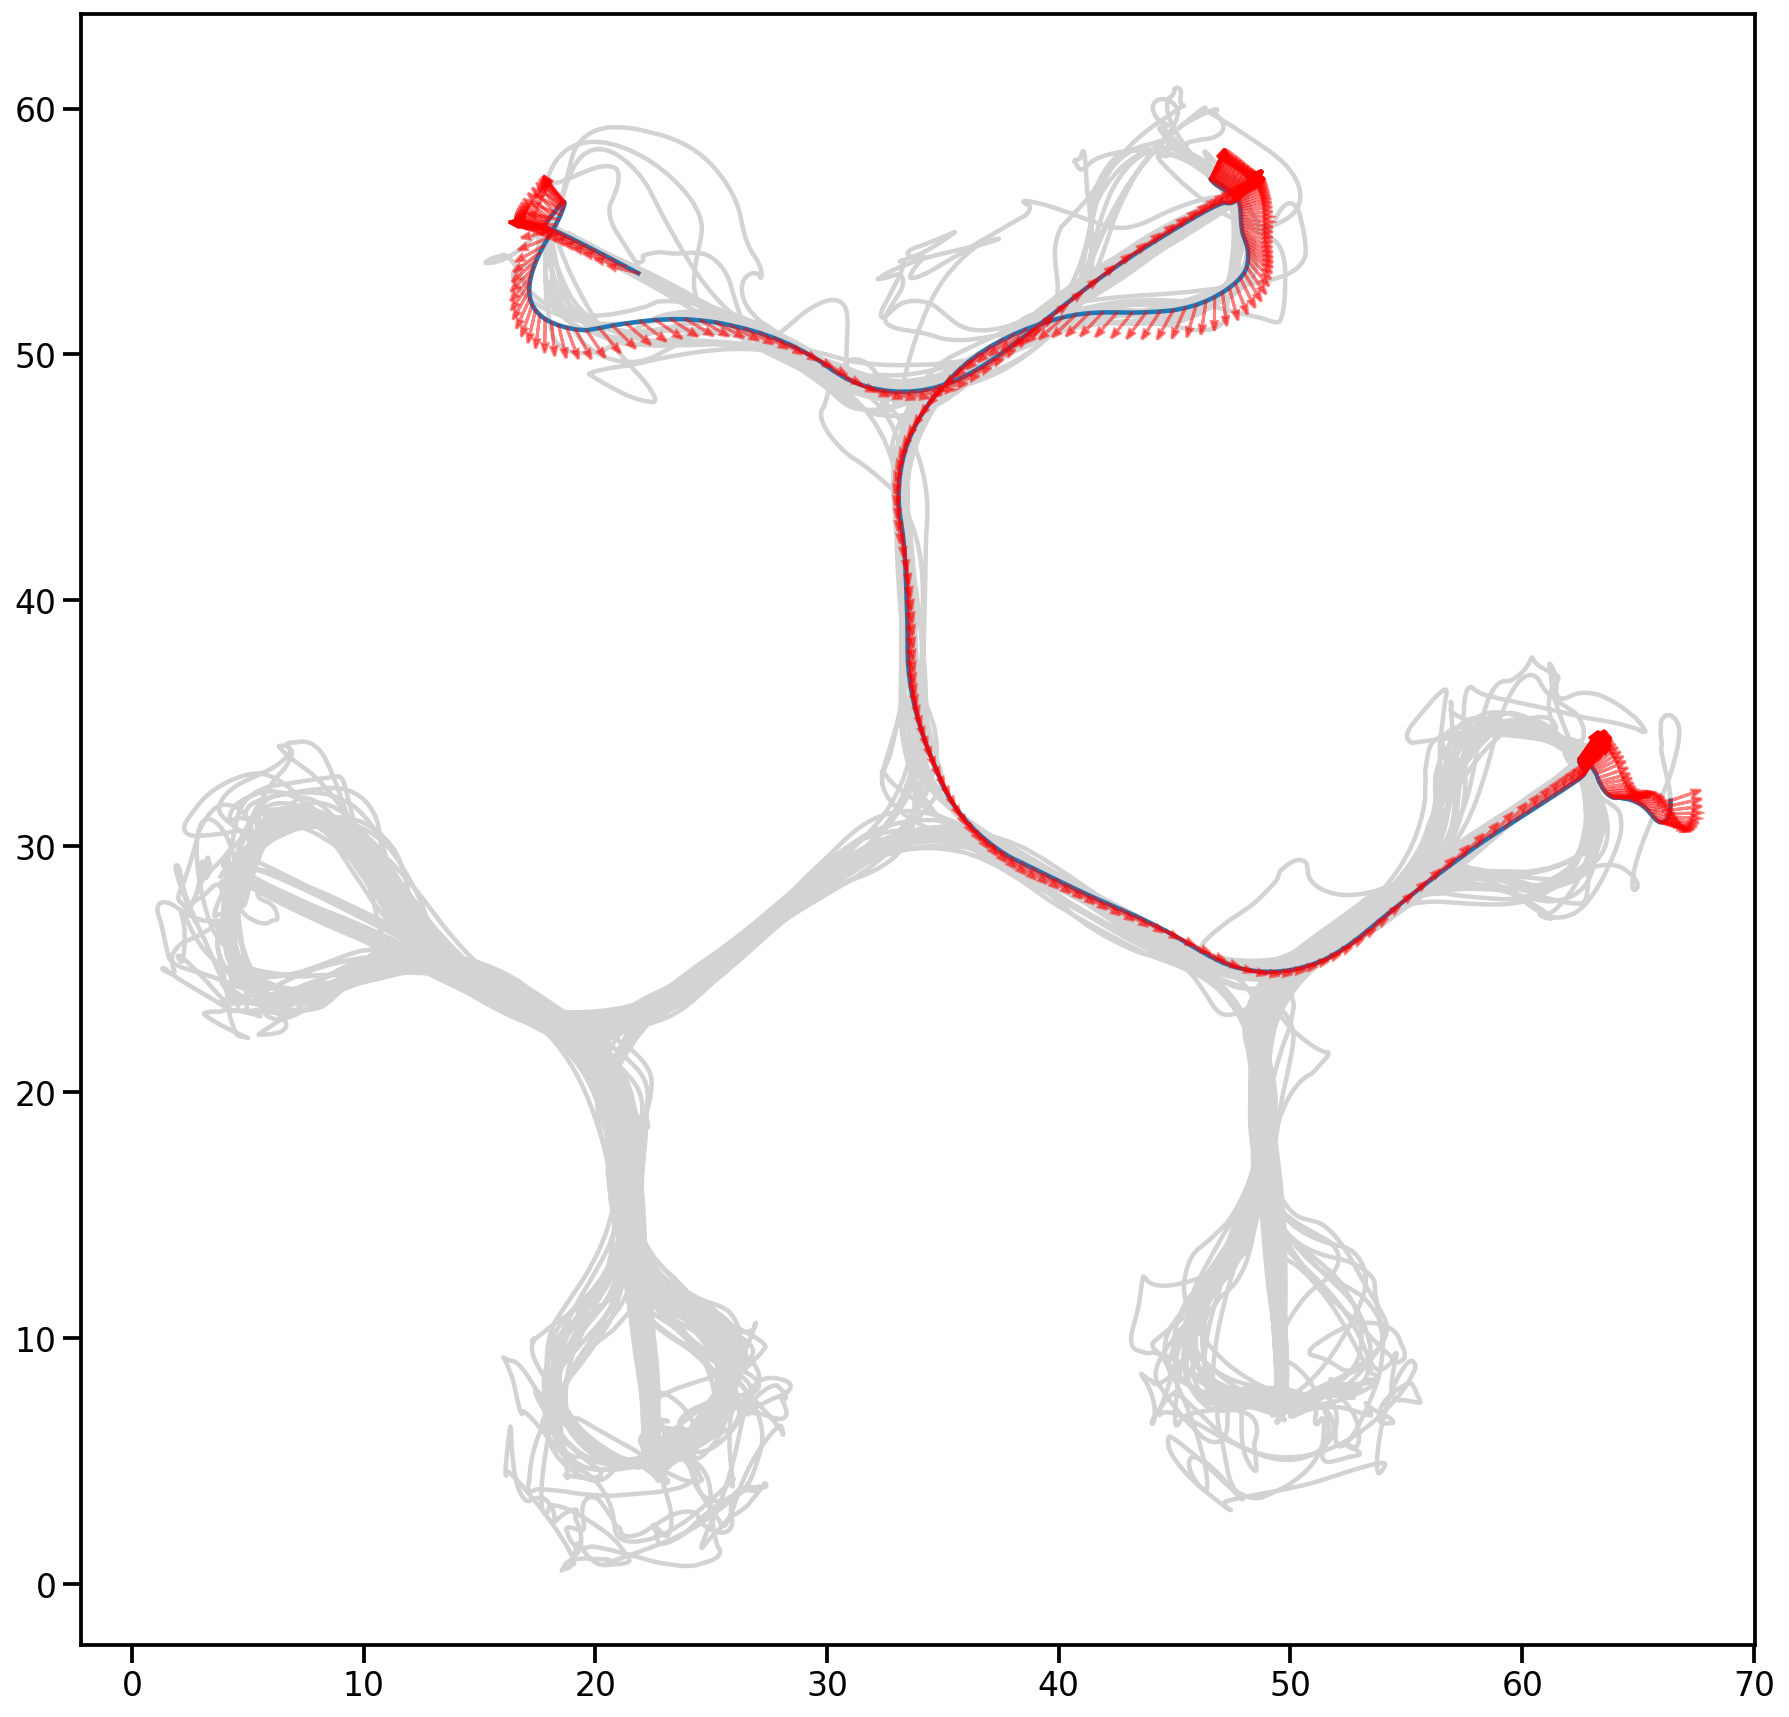

In [127]:
time_slice = slice(675, 1300)

plt.figure(figsize=(15, 15))
plt.plot(position_info.x_position, position_info.y_position, color="lightgrey")
plt.plot(
    position_info.iloc[time_slice].x_position, position_info.iloc[time_slice].y_position
)

for ind in range(time_slice.start, time_slice.stop):
    plot_arrow(ind, radius=1, head_width=0.25, alpha=0.5, color="red", zorder=10)

In [7]:
def plot_projected_arrow(time_slice, radius=1, **kwargs):
    x = position_info.iloc[time_slice].projected_x_position
    y = position_info.iloc[time_slice].projected_y_position
    angle = position_info.iloc[time_slice].head_direction

    plt.arrow(x, y, radius * np.cos(angle), radius * np.sin(angle), **kwargs)

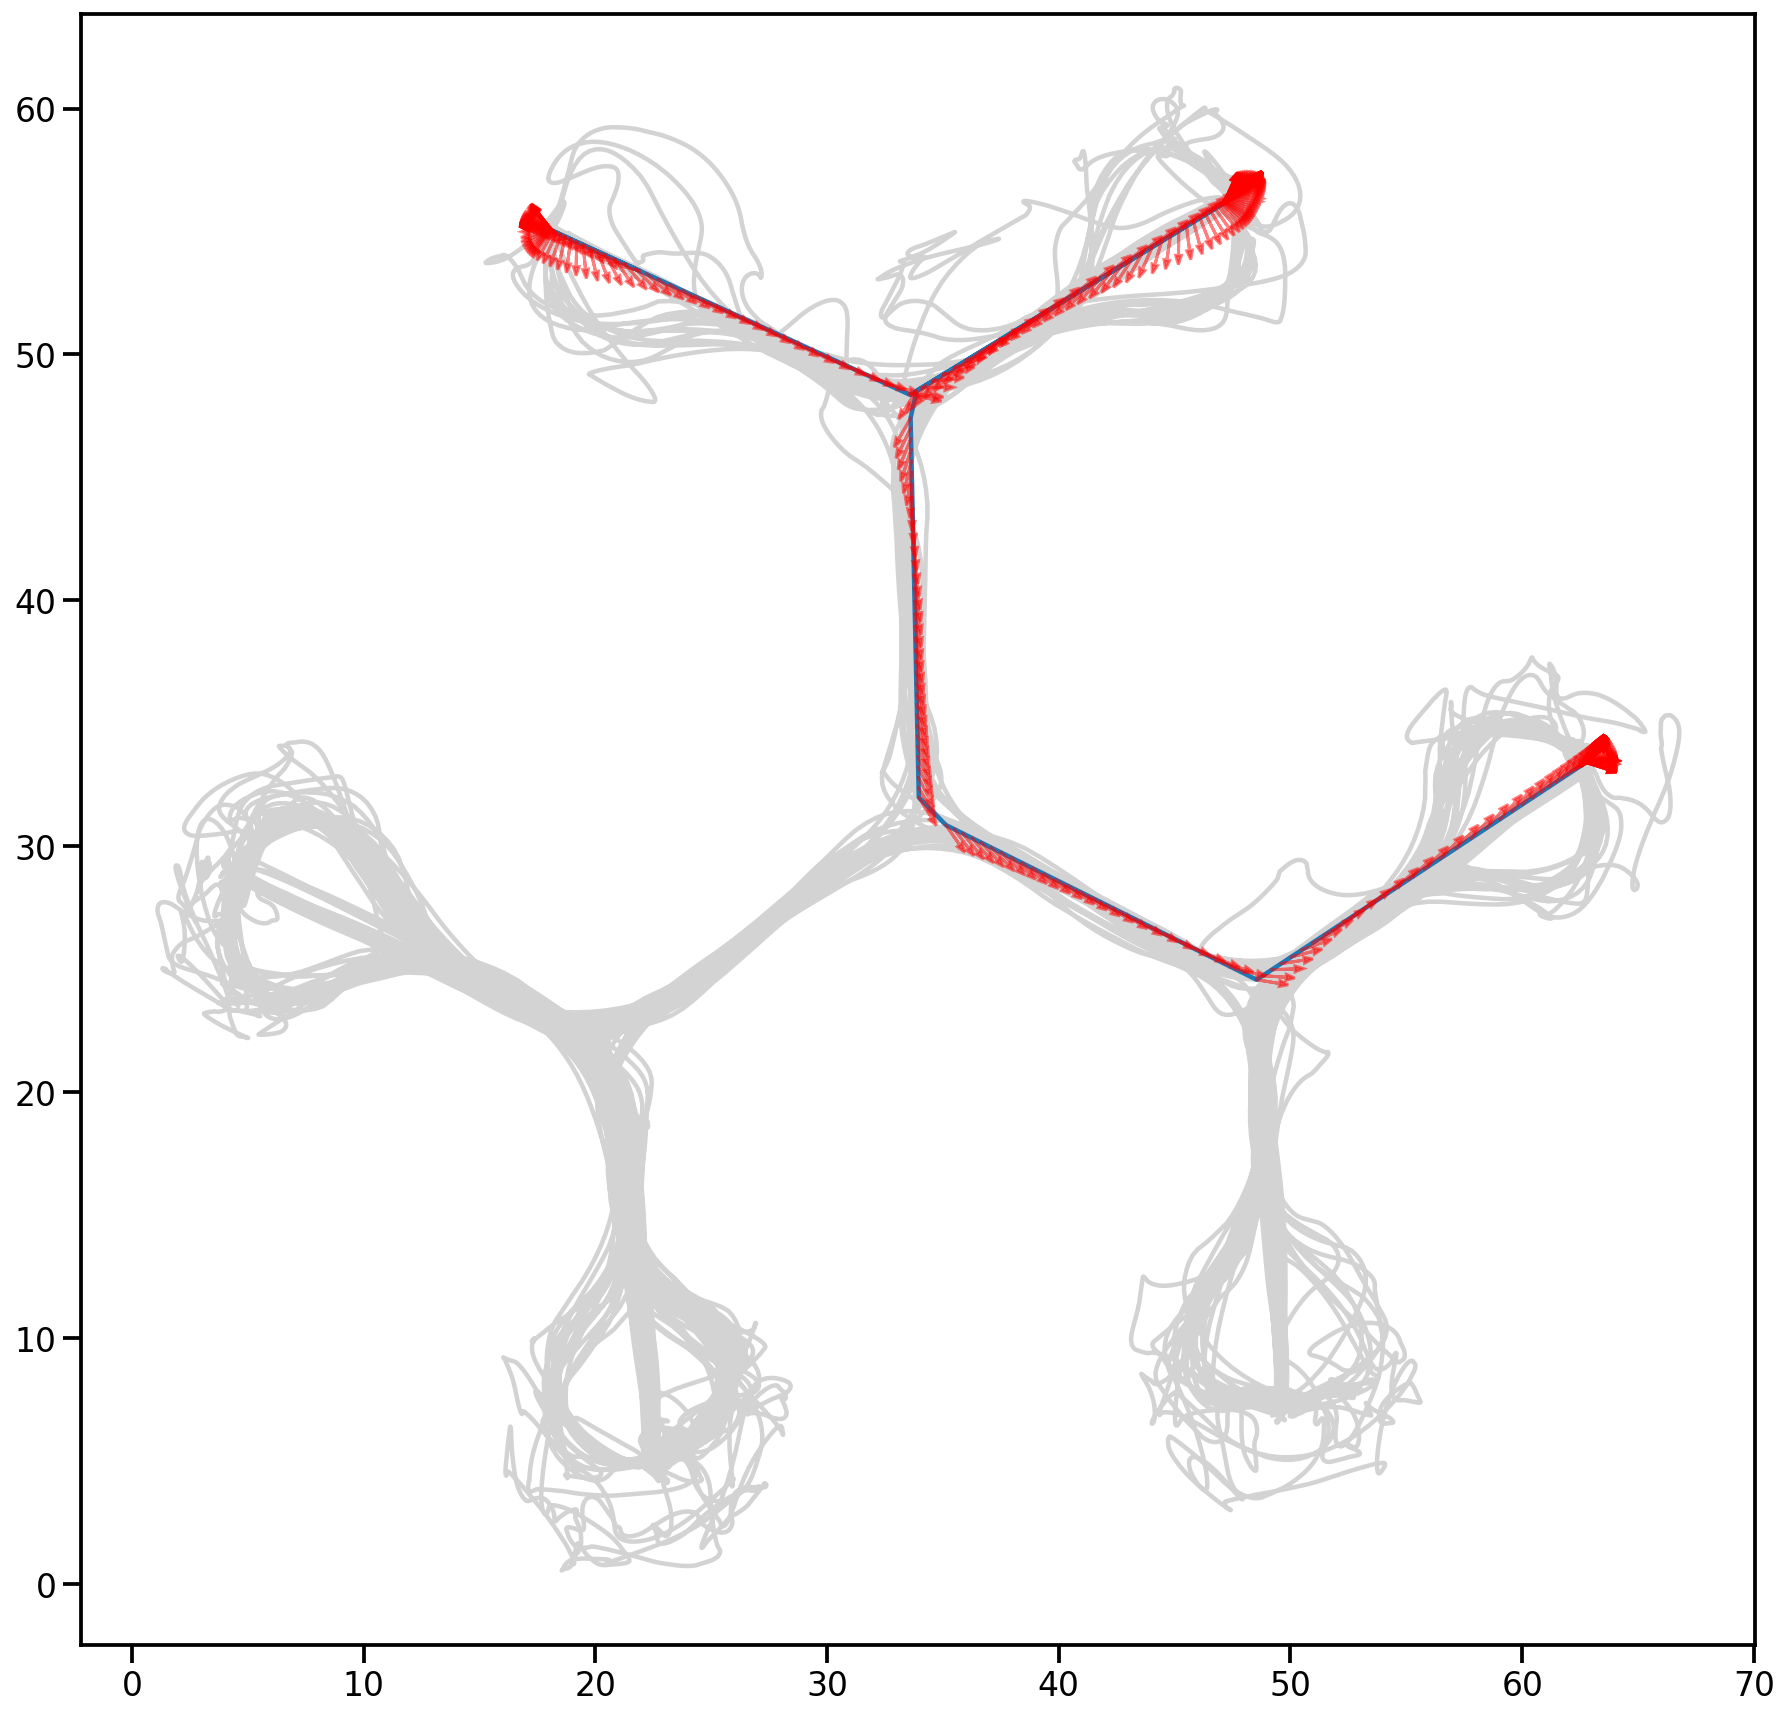

In [8]:
time_slice = slice(675, 1300)

plt.figure(figsize=(15, 15))
plt.plot(position_info.x_position, position_info.y_position, color="lightgrey")
plt.plot(
    position_info.iloc[time_slice].projected_x_position,
    position_info.iloc[time_slice].projected_y_position,
)

for ind in range(time_slice.start, time_slice.stop):
    plot_projected_arrow(
        ind, radius=1, head_width=0.25, alpha=0.5, color="red", zorder=10
    )

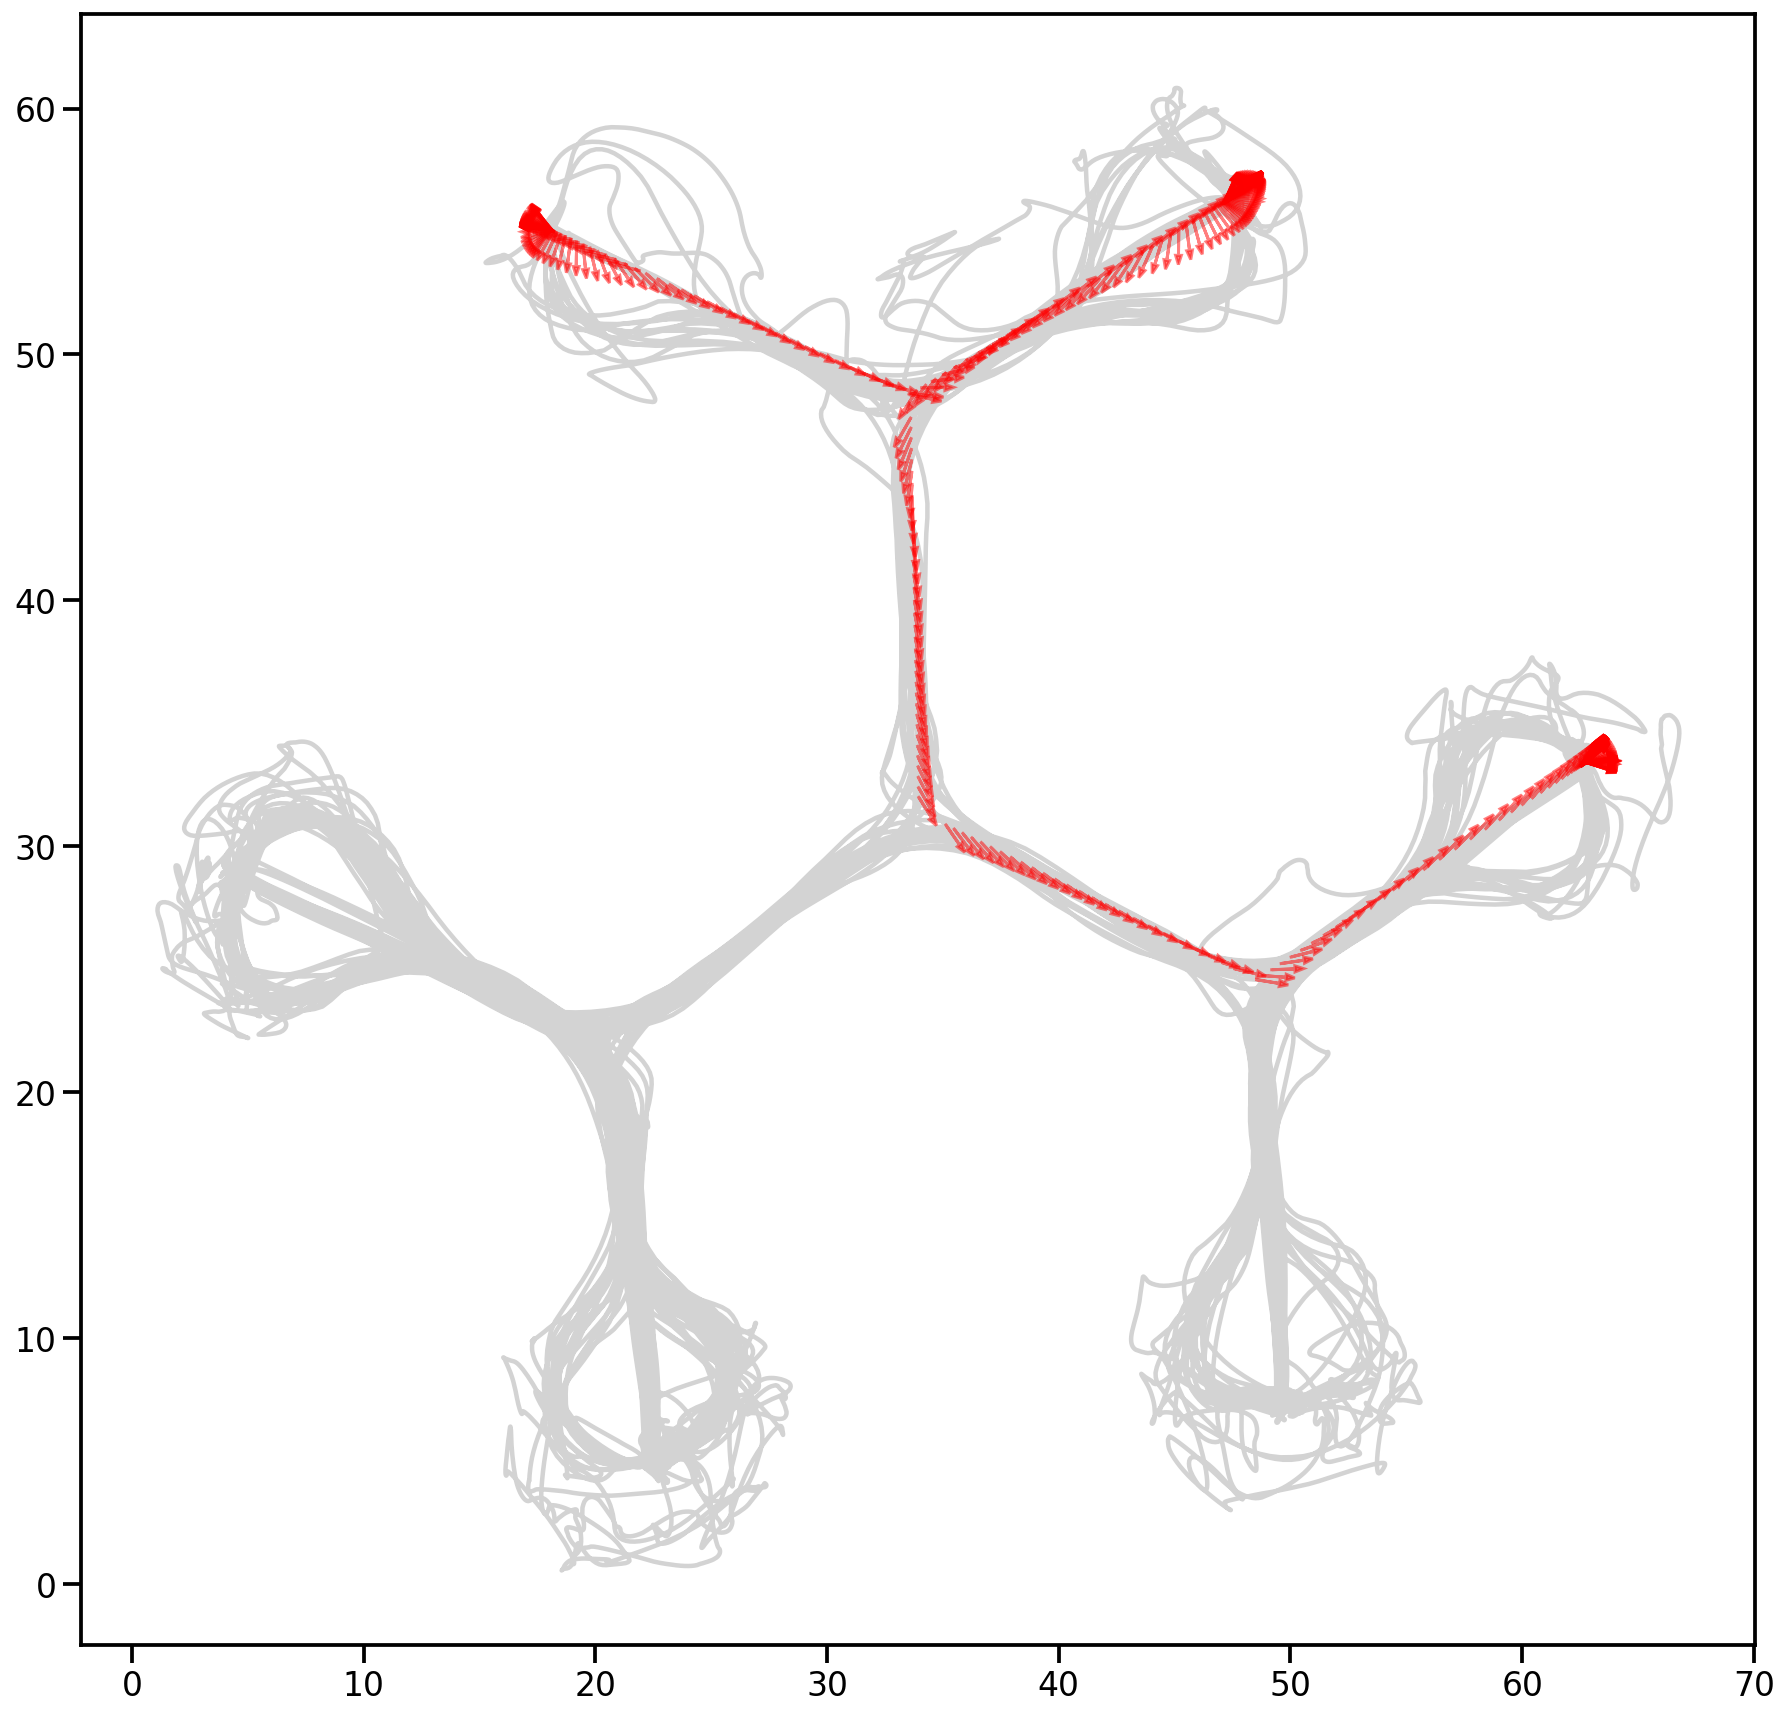

In [9]:
plt.figure(figsize=(15, 15))
plt.plot(position_info.x_position, position_info.y_position, color="lightgrey")
for ind in range(675, 1300):
    plot_projected_arrow(
        ind, radius=1, head_width=0.25, alpha=0.5, color="red", zorder=10
    )

In [10]:
from loren_frank_data_processing.track_segment_classification import (
    project_points_to_segment,
    get_track_segments_from_graph,
)

radius = 1

track_graph, center_well_id = make_track_graph()
track_segments = get_track_segments_from_graph(track_graph)
x = position_info.iloc[time_slice].x_position.values
y = position_info.iloc[time_slice].y_position.values
angle = position_info.iloc[time_slice].head_direction.values

x2 = x + radius * np.cos(angle)
y2 = y + radius * np.sin(angle)
position = np.stack([x2, y2], axis=1)
track_segment_id = position_info.iloc[time_slice].track_segment_id.values.astype(int)

projected_track_positions = project_points_to_segment(track_segments, position)
n_time = projected_track_positions.shape[0]
projected_track_positions = projected_track_positions[
    (np.arange(n_time), track_segment_id)
]

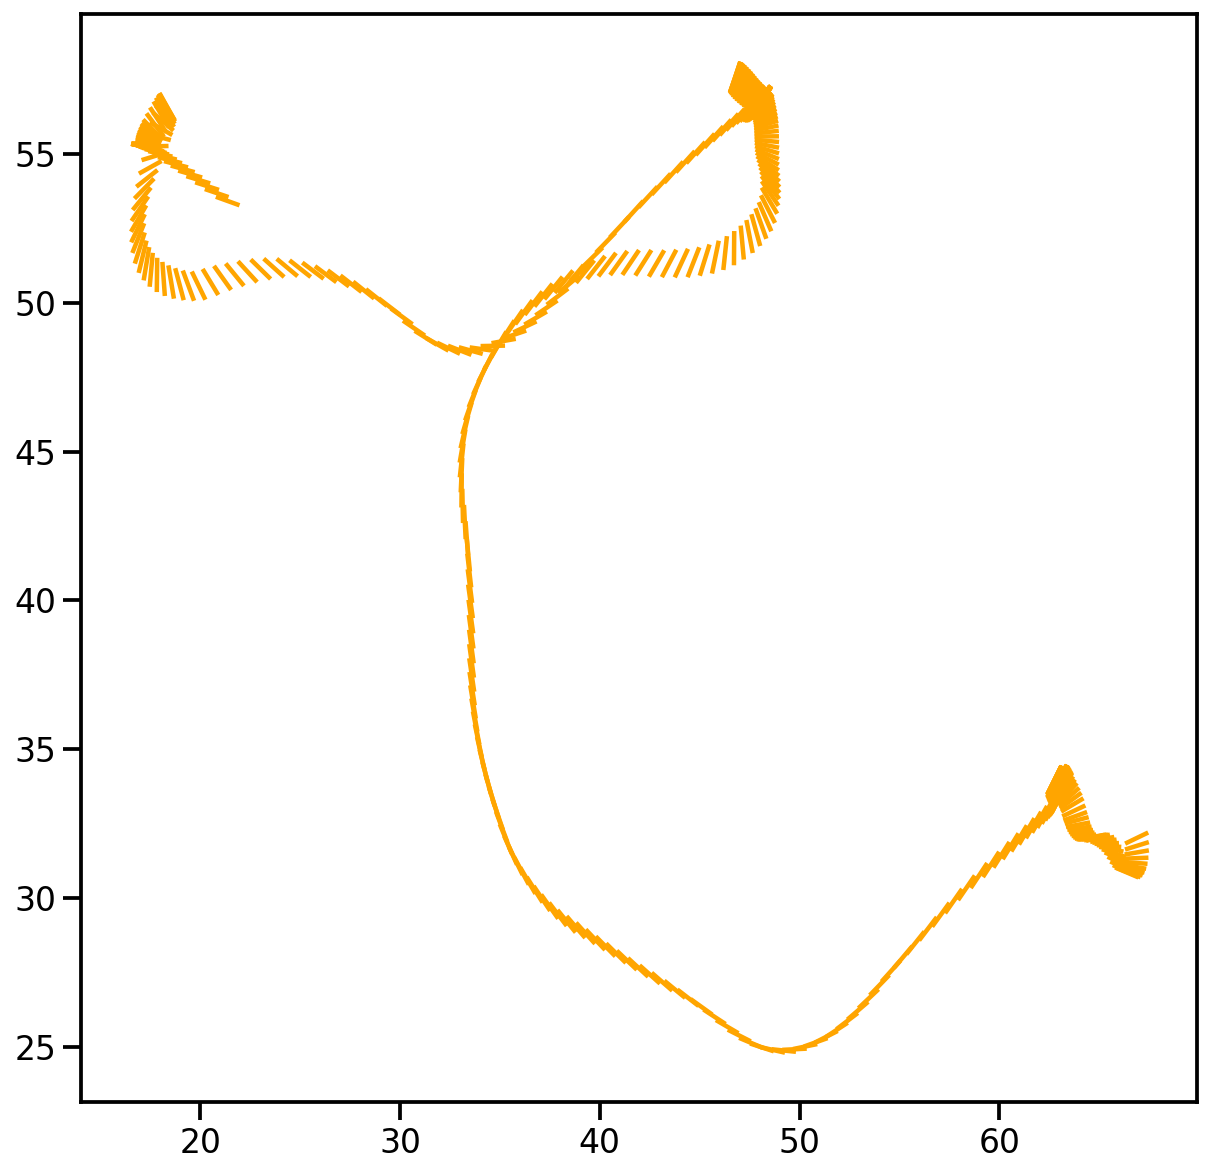

In [11]:
plt.figure(figsize=(10, 10))
_ = plt.plot([x, x2], [y, y2], color="orange")

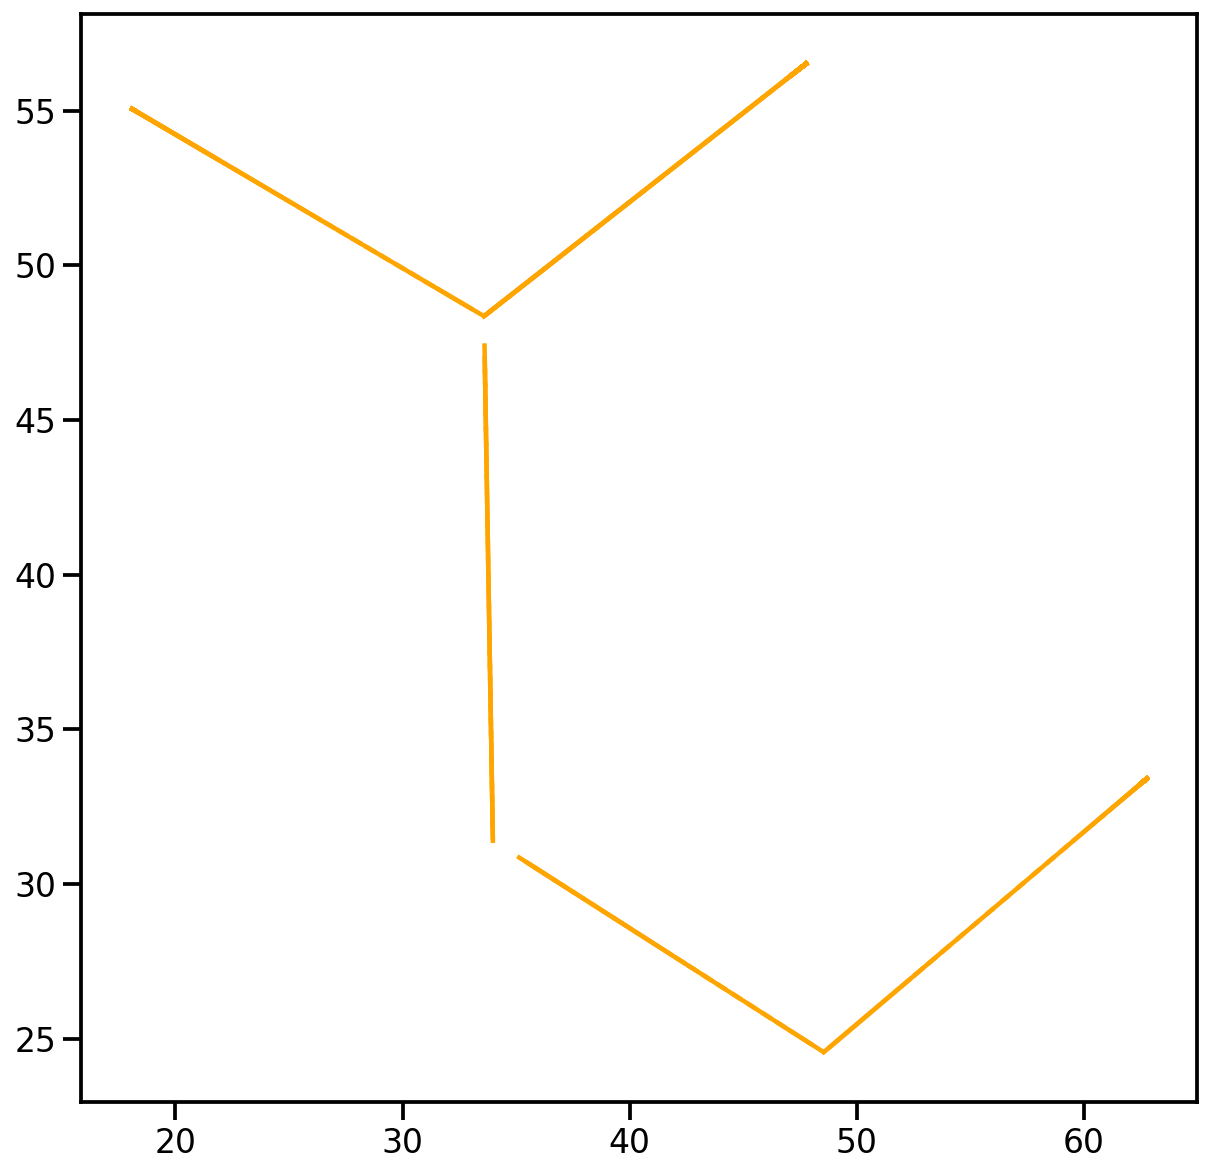

In [12]:
plt.figure(figsize=(10, 10))
projected_x = position_info.iloc[time_slice].projected_x_position.values.squeeze()
projected_y = position_info.iloc[time_slice].projected_y_position.values.squeeze()
x4, y4 = projected_track_positions[:, 0], projected_track_positions[:, 1]
_ = plt.plot([projected_x, x4], [projected_y, y4], color="orange")

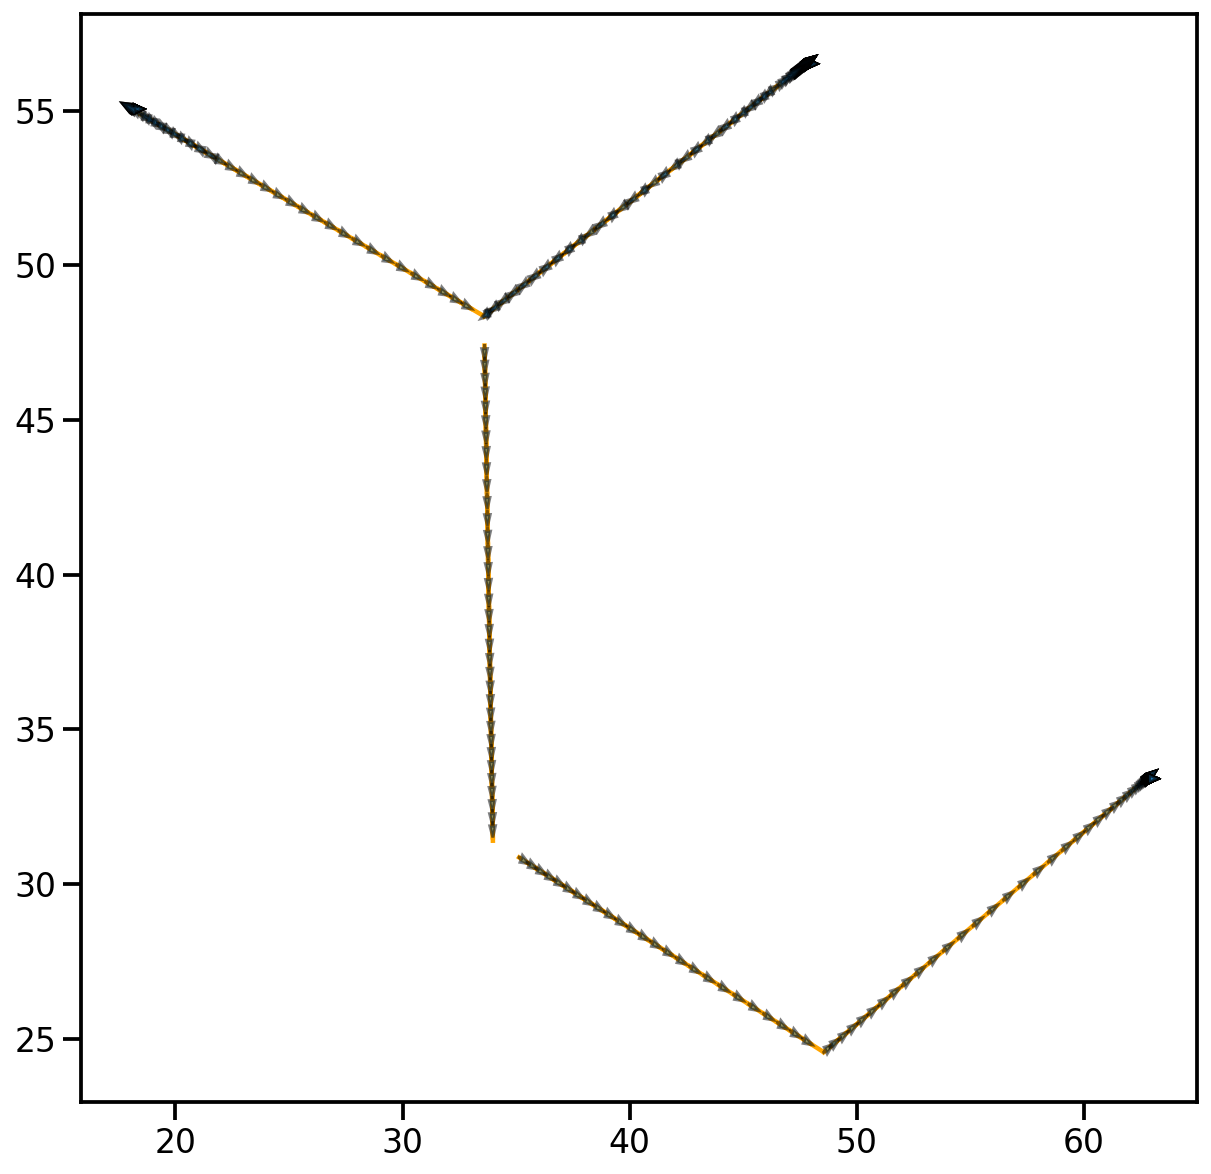

In [41]:
radius = 0.1
x3 = position_info.iloc[time_slice].projected_x_position.values.squeeze()
y3 = position_info.iloc[time_slice].projected_y_position.values.squeeze()
x4, y4 = projected_track_positions[:, 0], projected_track_positions[:, 1]
angle2 = np.arctan2(y4 - y3, x4 - x3)

plt.figure(figsize=(10, 10))
_ = plt.plot([x3, x4], [y3, y4], color="orange")
for x, y, angle in zip(x3, y3, angle2):
    plt.arrow(
        x,
        y,
        radius * np.cos(angle),
        radius * np.sin(angle),
        zorder=100,
        head_width=0.25,
        alpha=0.5,
    )

In [33]:
projected_x = position_info.iloc[time_slice].projected_x_position.values.squeeze()
projected_y = position_info.iloc[time_slice].projected_y_position.values.squeeze()
x4, y4 = projected_track_positions[:, 0], projected_track_positions[:, 1]
angle2 = np.arctan2(y4 - projected_y, x4 - projected_x)
radius * np.cos(angle), y + radius * np.sin(angle)

array([[21.89662313, 53.40812184],
       [21.33450609, 53.6510818 ],
       [20.84261398, 53.86368892],
       ...,
       [62.755     , 33.41      ],
       [62.755     , 33.41      ],
       [62.755     , 33.41      ]])

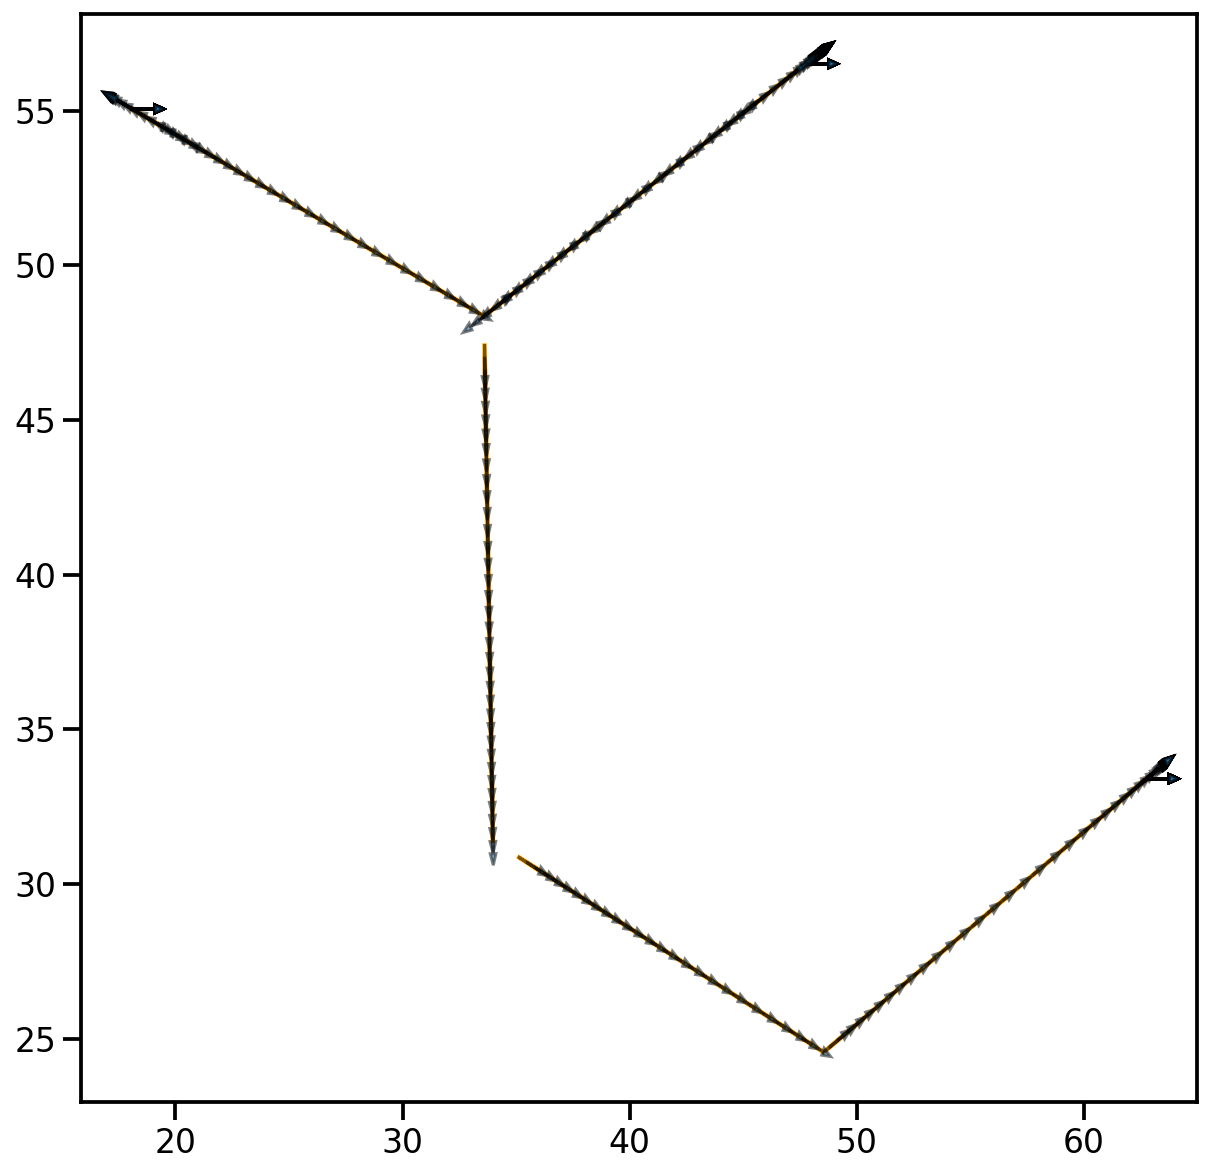

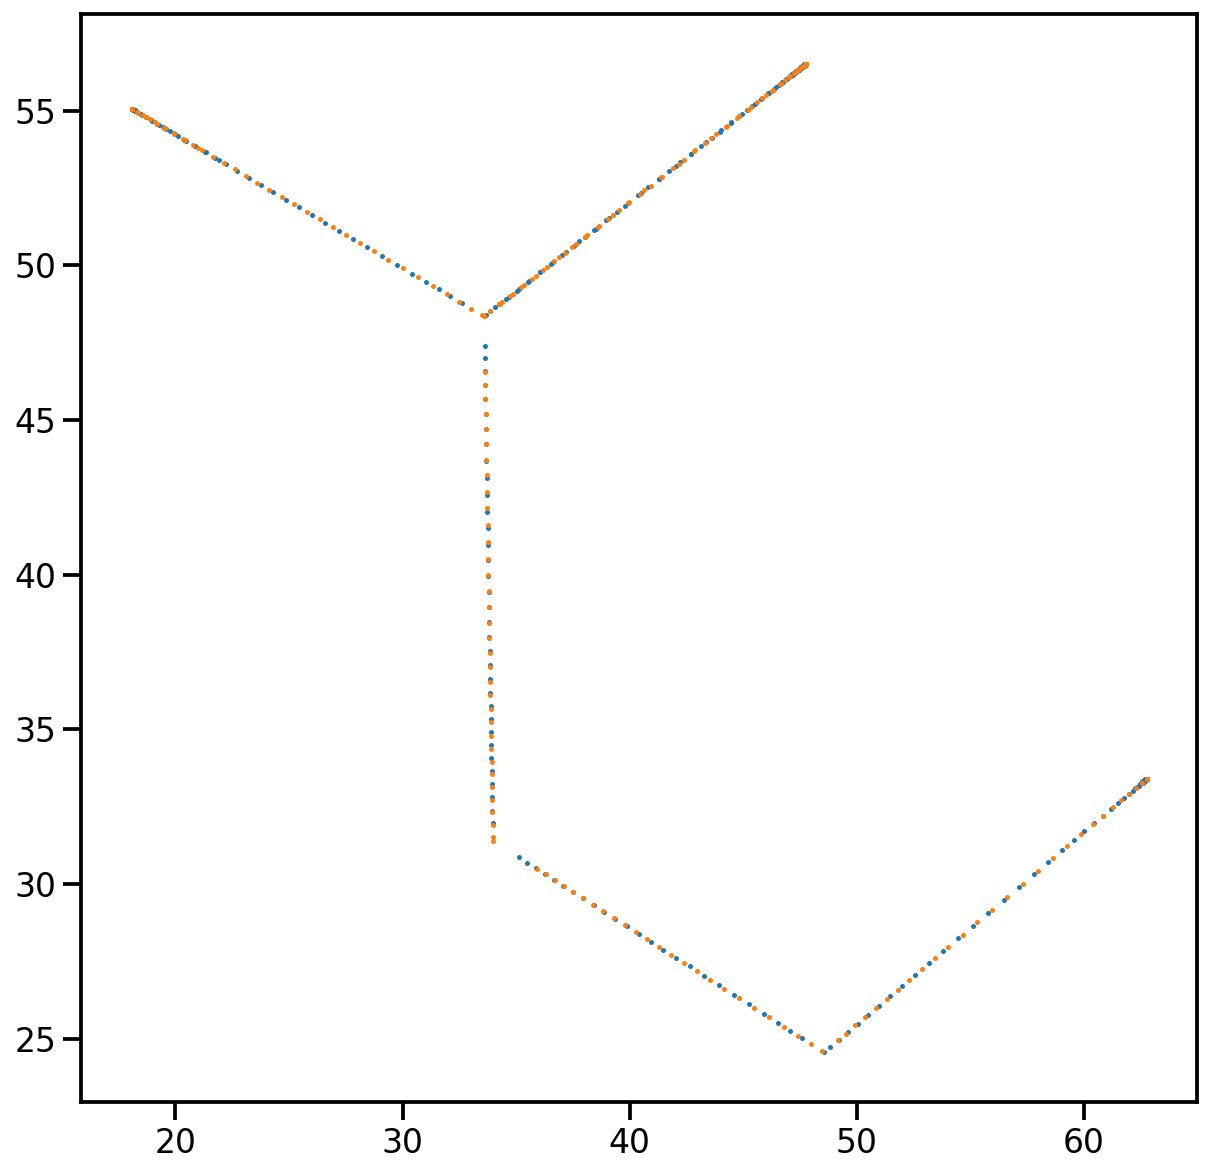

In [57]:
from loren_frank_data_processing.track_segment_classification import (
    project_points_to_segment,
    get_track_segments_from_graph,
)

radius = 1

track_graph, center_well_id = make_track_graph()
track_segments = get_track_segments_from_graph(track_graph)
x = position_info.iloc[time_slice].x_position.values
y = position_info.iloc[time_slice].y_position.values
projected_x = position_info.iloc[time_slice].projected_x_position.values.squeeze()
projected_y = position_info.iloc[time_slice].projected_y_position.values.squeeze()
angle = position_info.iloc[time_slice].head_direction.values

arrow2D_x = projected_x + radius * np.cos(angle)
arrow2D_y = projected_y + radius * np.sin(angle)

arrow2D_position = np.stack([arrow2D_x, arrow2D_y], axis=1)
track_segment_id = position_info.iloc[time_slice].track_segment_id.values.astype(int)

projected_arrow_position = project_points_to_segment(track_segments, arrow2D_position)
n_time = projected_arrow_position.shape[0]
projected_arrow_position = projected_arrow_position[
    (np.arange(n_time), track_segment_id)
]

angle2 = np.arctan2(
    projected_arrow_position[:, 1] - projected_y,
    projected_arrow_position[:, 0] - projected_x,
)

plt.figure(figsize=(10, 10))
_ = plt.plot(
    [projected_x, projected_arrow_position[:, 0]],
    [projected_y, projected_arrow_position[:, 1]],
    color="orange",
)
for x, y, angle in zip(projected_x, projected_y, angle2):
    plt.arrow(
        x,
        y,
        radius * np.cos(angle),
        radius * np.sin(angle),
        zorder=100,
        head_width=0.25,
        alpha=0.5,
    )

plt.figure(figsize=(10, 10))
_ = plt.scatter(projected_x, projected_y, s=1)
_ = plt.scatter(projected_arrow_position[:, 0], projected_arrow_position[:, 1], s=1)

In [131]:
from src.analysis import add_node, _get_animal_2d_projected_position_edges

track_graph, center_well_id = make_track_graph()
position_2D = position_info.iloc[time_slice][["x_position", "y_position"]].values
track_segment_id = position_info.iloc[time_slice].track_segment_id.values.astype(int)
(actual_projected_position, actual_edges) = _get_animal_2d_projected_position_edges(
    track_graph, position_2D, track_segment_id
)

projected_x = position_info.iloc[time_slice].projected_x_position.values.squeeze()
projected_y = position_info.iloc[time_slice].projected_y_position.values.squeeze()
angle = position_info.iloc[time_slice].head_direction.values

arrow2D_x = projected_x + radius * np.cos(angle)
arrow2D_y = projected_y + radius * np.sin(angle)
arrow2D = np.stack((arrow2D_x, arrow2D_y), axis=1)
(
    projected_arrow_position,
    projected_arrow_edges,
) = _get_animal_2d_projected_position_edges(track_graph, arrow2D, track_segment_id)

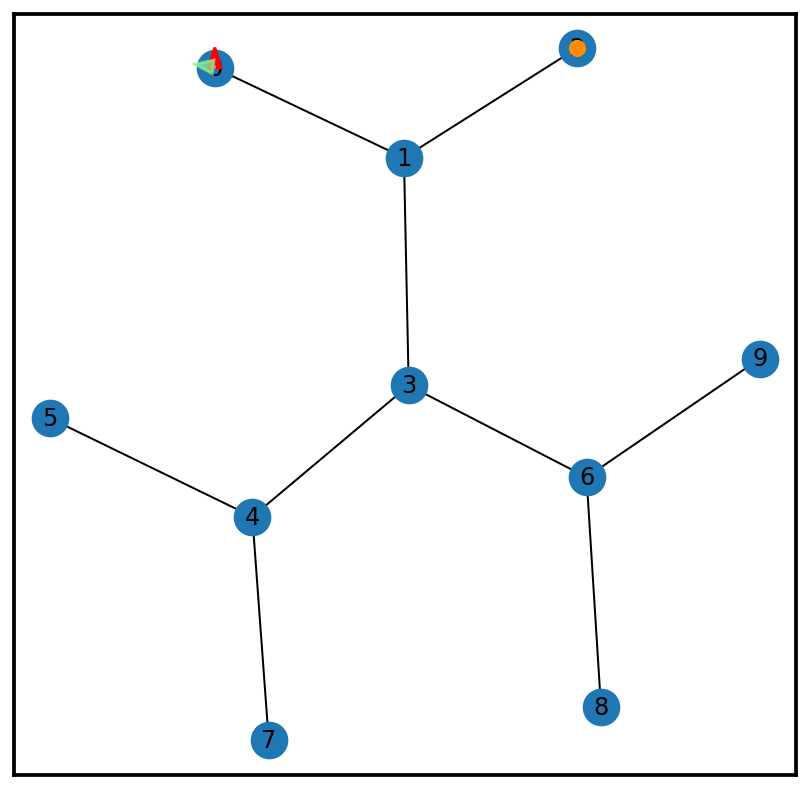

In [222]:
import networkx as nx

time_ind = 13
actual_pos = actual_projected_position[time_ind]
actual_edge = actual_edges[time_ind]
arrow_pos = projected_arrow_position[time_ind]
arrow_edge = projected_arrow_edges[time_ind]
map_pos = actual_projected_position[200]
map_edge = actual_edges[200]

copy_graph = track_graph.copy()
add_node(actual_pos, actual_edge, copy_graph, "actual_position")
add_node(arrow_pos, arrow_edge, copy_graph, "arrow_position")
add_node(map_pos, map_edge, copy_graph, "map_position")


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.scatter(map_pos[0], map_pos[1], zorder=100, color="darkorange", s=50)

plt.arrow(
    actual_pos[0],
    actual_pos[1],
    arrow_pos[0] - actual_pos[0],
    arrow_pos[1] - actual_pos[1],
    zorder=200,
    head_width=1,
    alpha=1,
    color="red",
)

plt.arrow(
    position_info.iloc[time_slice].x_position.values[time_ind],
    position_info.iloc[time_slice].y_position.values[time_ind],
    0.1 * np.cos(angle[time_ind]),
    0.1 * np.sin(angle[time_ind]),
    zorder=200,
    head_width=1,
    alpha=0.75,
    color="lightgreen",
)

(-2.0, 2.0)

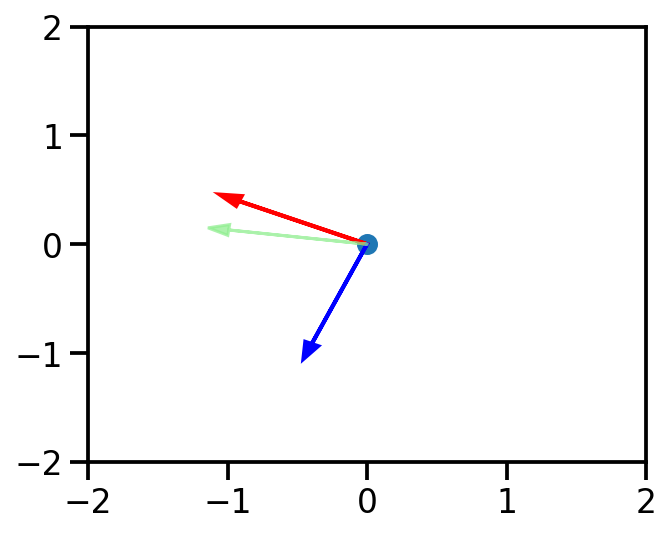

In [313]:
def get_edge_angle(edge_ids, track_graph):
    x1, y1 = track_graph.nodes[edge_ids[1]]["pos"]
    x2, y2 = track_graph.nodes[edge_ids[0]]["pos"]
    return np.arctan2(y2 - y1, x2 - x1)


fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(0, 0)
edge_angle = get_edge_angle([0, 1], track_graph)
plt.arrow(
    0,
    0,
    1 * np.cos(edge_angle),
    1 * np.sin(edge_angle),
    zorder=200,
    linewidth=2,
    head_width=0.1,
    alpha=1,
    color="red",
)
plt.arrow(
    0,
    0,
    1 * np.cos(edge_angle + np.pi / 2),
    1 * np.sin(edge_angle + np.pi / 2),
    zorder=200,
    linewidth=2,
    head_width=0.1,
    alpha=1,
    color="blue",
)
plt.arrow(
    0,
    0,
    1 * np.cos(angle[time_ind]),
    1 * np.sin(angle[time_ind]),
    zorder=200,
    head_width=0.1,
    alpha=0.75,
    color="lightgreen",
)
plt.xlim((-2, 2))
plt.ylim((-2, 2))

(-2.0, 2.0)

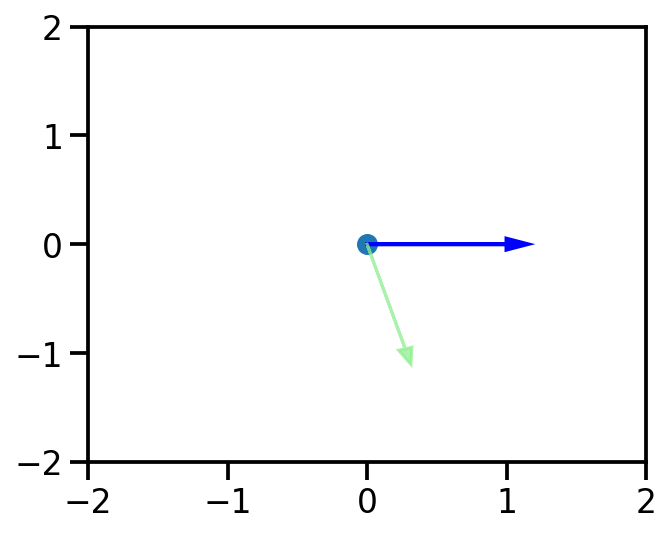

In [315]:
def get_edge_angle(edge_ids, track_graph):
    x1, y1 = track_graph.nodes[edge_ids[1]]["pos"]
    x2, y2 = track_graph.nodes[edge_ids[0]]["pos"]
    return np.arctan2(y2 - y1, x2 - x1)


fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(0, 0)
edge_angle = get_edge_angle([0, 1], track_graph)
plt.arrow(
    0,
    0,
    1 * np.cos(0),
    1 * np.sin(0),
    zorder=200,
    linewidth=2,
    head_width=0.1,
    alpha=1,
    color="blue",
)
plt.arrow(
    0,
    0,
    1 * np.cos(angle[time_ind] - (edge_angle + np.pi / 2)),
    1 * np.sin(angle[time_ind] - (edge_angle + np.pi / 2)),
    zorder=200,
    head_width=0.1,
    alpha=0.75,
    color="lightgreen",
)
plt.xlim((-2, 2))
plt.ylim((-2, 2))

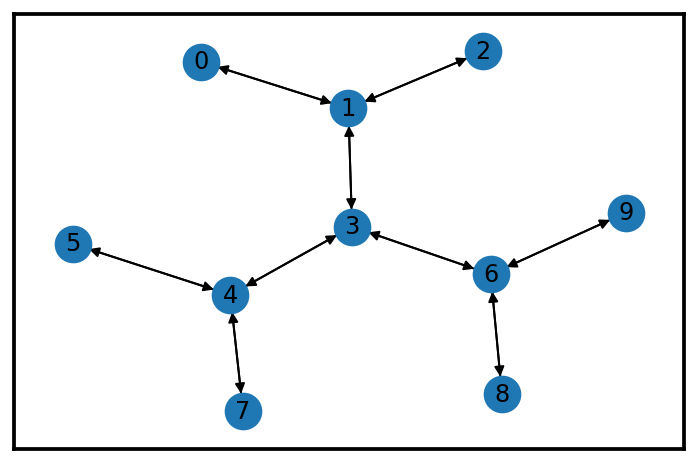

In [323]:
node_position = nx.get_node_attributes(nx.to_directed(track_graph), "pos")
nx.draw_networkx(nx.to_directed(track_graph), node_position, ax)

In [324]:
nx.to_directed(track_graph).edges

OutEdgeView([(0, 1), (1, 0), (1, 2), (1, 3), (2, 1), (3, 1), (3, 4), (3, 6), (4, 3), (4, 5), (4, 7), (5, 4), (6, 3), (6, 9), (6, 8), (7, 4), (8, 6), (9, 6)])

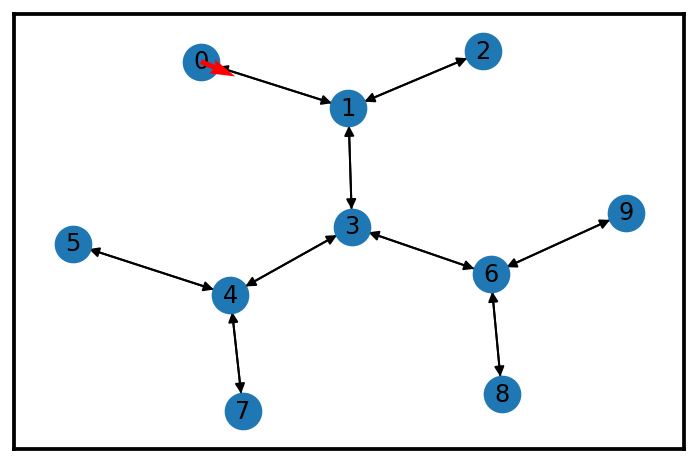

In [470]:
node1, node2 = [0, 1]
edge_vector = np.asarray(track_graph.nodes[node2]["pos"]) - np.asarray(
    track_graph.nodes[node1]["pos"]
)
node_position = nx.get_node_attributes(nx.to_directed(track_graph), "pos")
nx.draw_networkx(nx.to_directed(track_graph), node_position, ax)
plt.quiver(
    *node_position[node1], edge_vector[0], edge_vector[1], color="red", zorder=100
)

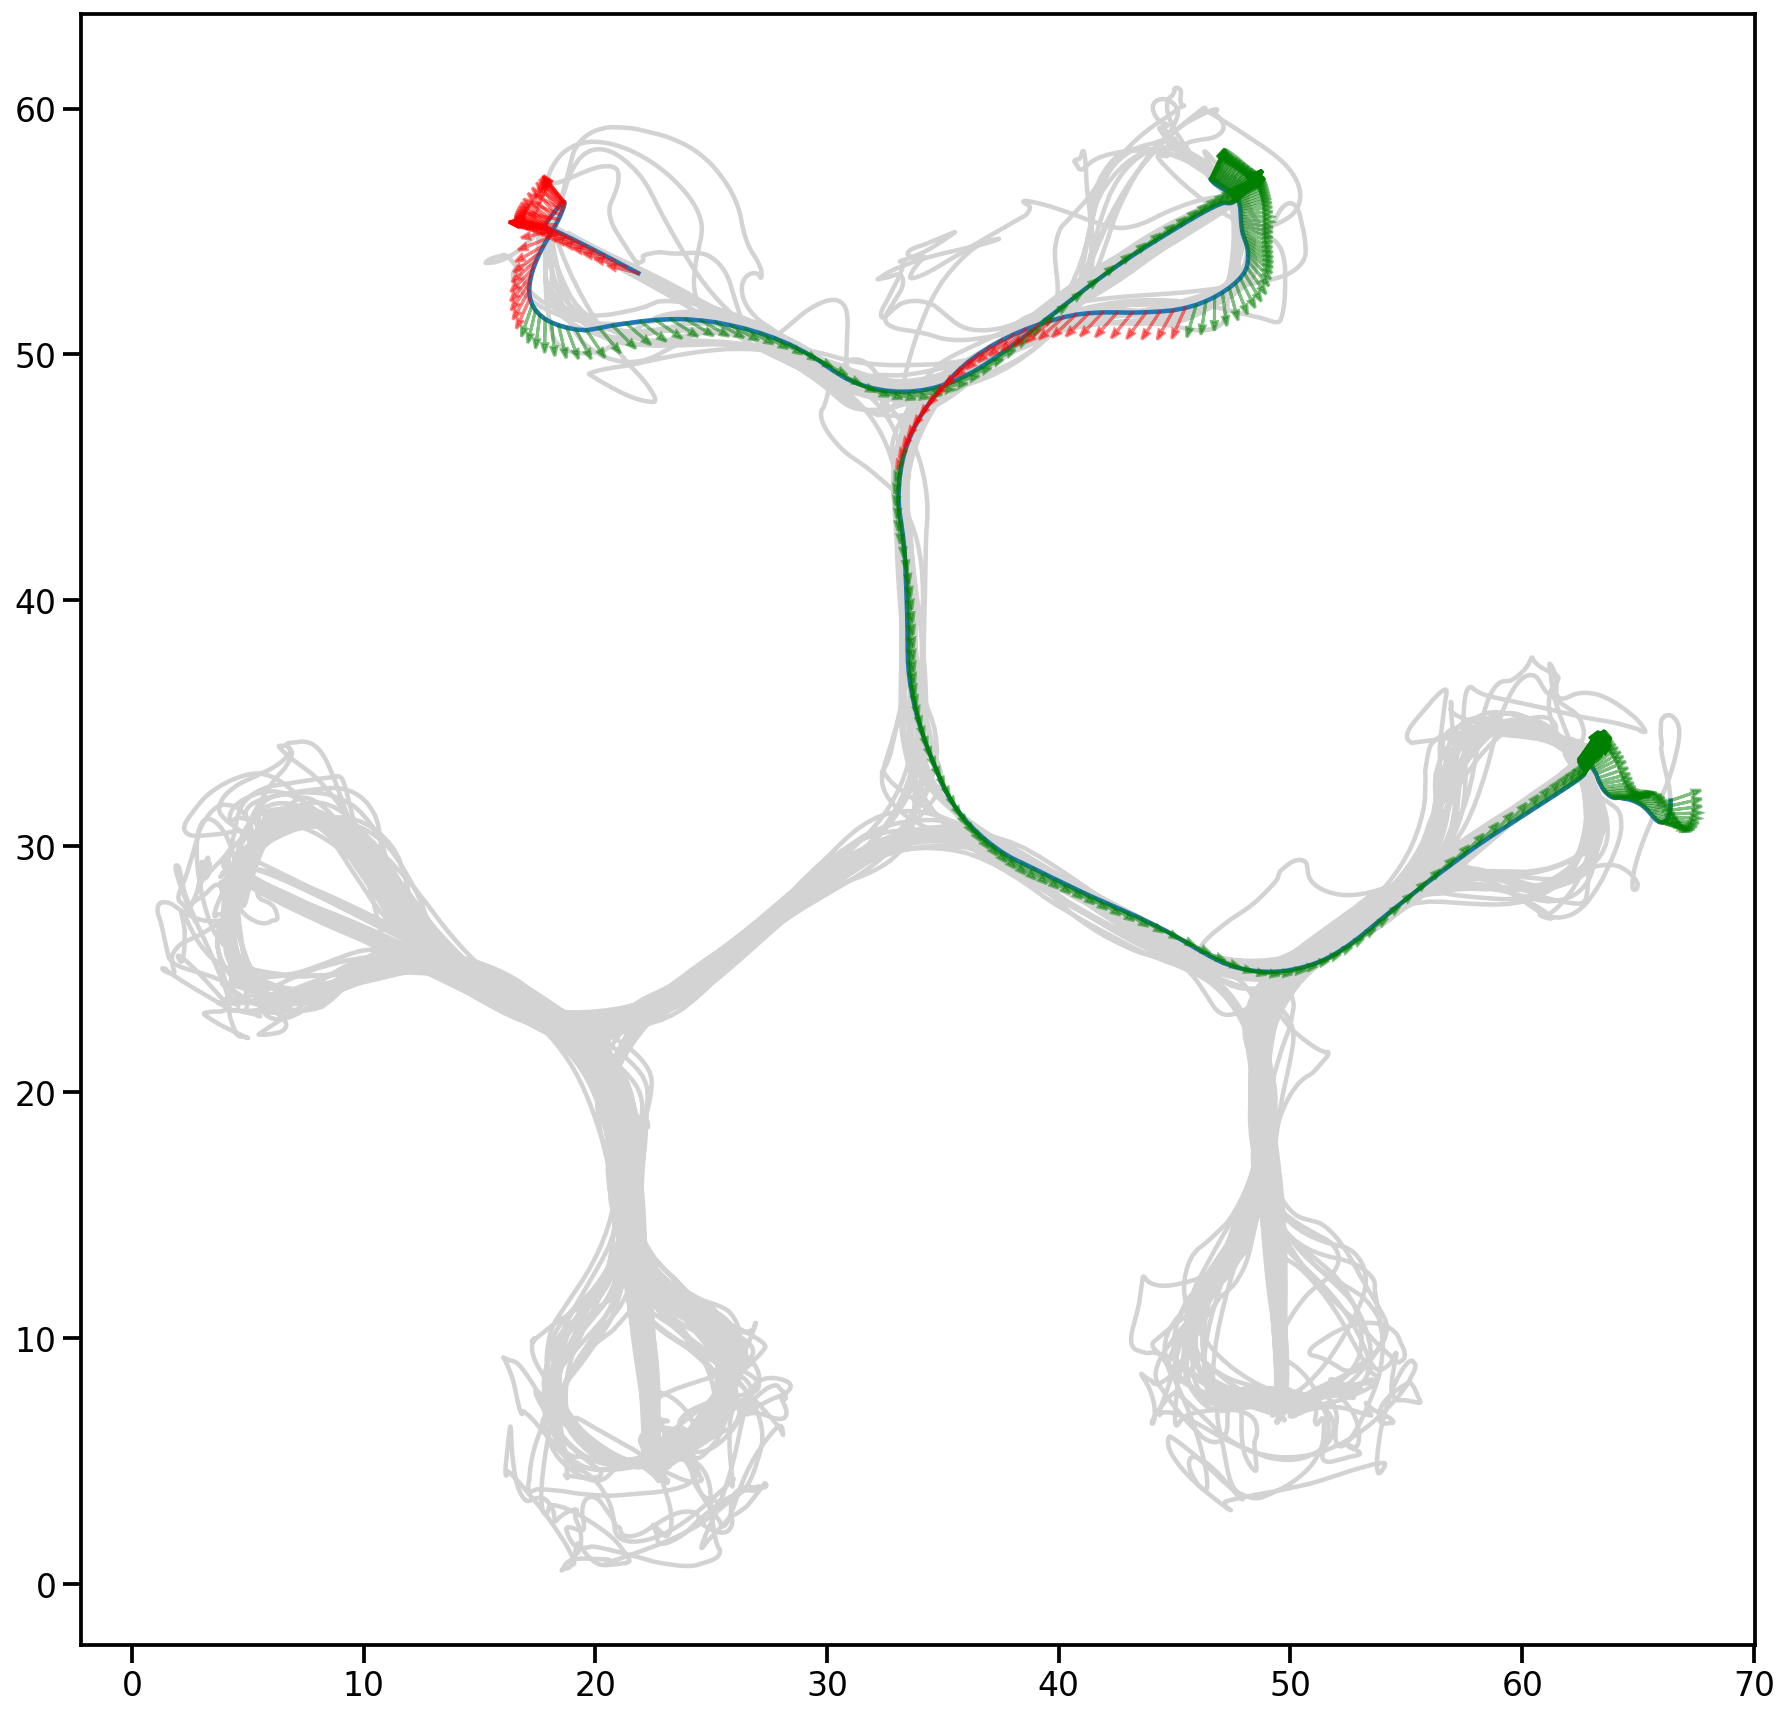

In [483]:
node1, node2 = [0, 1]
edge_vector = np.asarray(track_graph.nodes[node2]["pos"]) - np.asarray(
    track_graph.nodes[node1]["pos"]
)
angle = position_info.iloc[time_slice].head_direction.values
head_vector = np.asarray([np.cos(angle), np.sin(angle)])
is_same_direction = edge_vector @ head_vector >= 0
time_slice = slice(675, 1300)

plt.figure(figsize=(15, 15))
plt.plot(position_info.x_position, position_info.y_position, color="lightgrey")
plt.plot(
    position_info.iloc[time_slice].x_position, position_info.iloc[time_slice].y_position
)

for ind, same_dir in zip(range(time_slice.start, time_slice.stop), is_same_direction):
    if same_dir:  # points toward node2
        plot_arrow(ind, radius=1, head_width=0.25, alpha=0.5, color="green", zorder=10)
    else:
        plot_arrow(ind, radius=1, head_width=0.25, alpha=0.5, color="red", zorder=10)

In [534]:
def points_toward_node(track_graph, edge, head_direction):
    """Given an edge, determine the node the head is pointed toward
    
    Parameters
    ----------
    track_graph : networkx.Graph
    edge : array-like, shape (2,)
    head_direction : array-like
        Angle of head in radians
    
    Returns
    -------
    node : object

    """
    edge = np.asarray(edge)
    node1_pos = np.asarray(track_graph.nodes[edge[0]]["pos"])
    node2_pos = np.asarray(track_graph.nodes[edge[1]]["pos"])
    edge_vector = node2_pos - node1_pos
    head_vector = np.asarray([np.cos(head_direction), np.sin(head_direction)])
    return edge[(edge_vector @ head_vector >= 0).astype(int)]


points_toward_node(track_graph, [3, 4], angle)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

-1.0

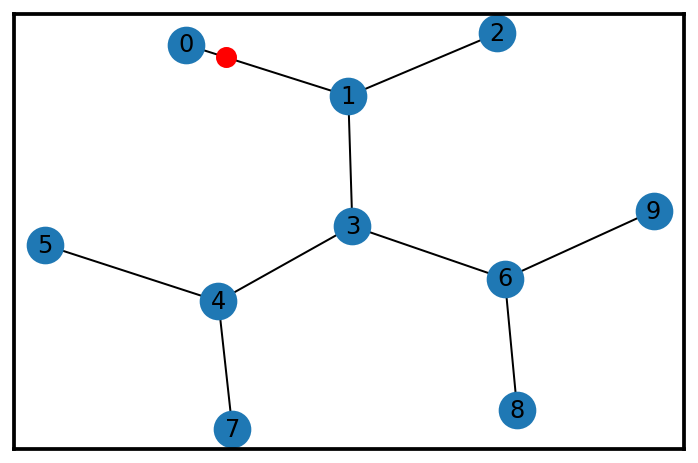

In [399]:
node1, node2 = [0, 1]
(x1, y1) = actual_projected_position[0]
(x2, y2) = track_graph.nodes[node2]["pos"]
(x, y) = track_graph.nodes[node1]["pos"]


d = (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
np.sign(d)

V = [y2 - y1, x1 - x2]
node_position = nx.get_node_attributes(track_graph, "pos")
nx.draw_networkx(track_graph, node_position, ax)
plt.scatter(x, y, color="red", zorder=100)


In [395]:
Given 𝐴=(𝑥1,𝑦1) and 𝐵=(𝑥2,𝑦2), define vector 𝑉 perpendicular to 𝐴𝐵→ as 𝑉=[𝑦2−𝑦1,𝑥1−𝑥2]. Then
𝑉⋅𝐴𝑃→=(𝑦2−𝑦1)(𝑥−𝑥1)+(𝑥1−𝑥2)(𝑦−𝑦1)

SyntaxError: invalid syntax (<ipython-input-395-0c66ed7d4cf7>, line 1)

03-Jul-20 16:31:57 Cannot parse: 1:6: Given 𝐴=(𝑥1,𝑦1) and 𝐵=(𝑥2,𝑦2), define vector 𝑉 perpendicular to 𝐴𝐵→ as 𝑉=[𝑦2−𝑦1,𝑥1−𝑥2]. Then
Traceback (most recent call last):
  File "/Users/edeno/miniconda3/envs/ac_clusterless_decoding/lib/python3.6/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/Users/edeno/miniconda3/envs/ac_clusterless_decoding/lib/python3.6/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "/Users/edeno/miniconda3/envs/ac_clusterless_decoding/lib/python3.6/site-packages/black.py", line 725, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "/Users/edeno/miniconda3/envs/ac_clusterless_decoding/lib/python3.6/site-packages/black.py", line 836, in lib2to3_parse
    raise exc from None
black.InvalidInput: Cannot parse: 1:6: Given 𝐴=(𝑥1,𝑦1) and 𝐵=(𝑥2,𝑦2), define vector 𝑉 perpendicular to 𝐴𝐵→ as 𝑉=[𝑦2−𝑦1,𝑥1−𝑥2]. Th

In [ ]:
(x1, y1) = track_graph.nodes[node1]["pos"]
(x2, y2) = track_graph.nodes[node2]["pos"]

In [420]:
def get_direction(A, B, point_of_interest):
    x1, y1 = A
    x2, y2 = B
    x, y = point_of_interest
    d = (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
    return np.sign(d)

In [424]:
get_direction(
    track_graph.nodes[node1]["pos"], track_graph.nodes[node2]["pos"], actual_pos - 1
)

1.0

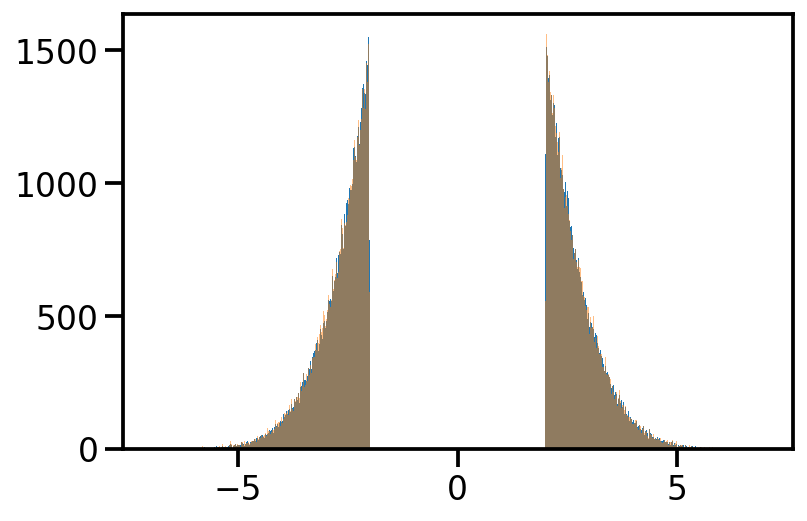

In [523]:
import scipy.stats

data = scipy.stats.norm.rvs(size=1000000, loc=0, scale=1.5, random_state=123)
data = data[(data > 2) | (data < -2)]
hist = np.histogram(data, bins=1000, density=True)

hist_dist = scipy.stats.rv_histogram(hist)
plt.hist(data, bins=1000)
_ = plt.hist(hist_dist.rvs(size=data.shape), bins=1000, alpha=0.5)

In [521]:
hist_dist.interval(alpha=0.95)

(-3.908100201684024, 3.9175213290195208)

In [538]:
def get_ahead_or_behind(
    track_graph, actual_pos, actual_edge, head_direction, mental_pos, mental_edge
):
    """
    
    Parameters
    ----------
    track_graph : nx.Graph
    actual_pos : array-like, shape (2,)
    mental_pos : array-like, shape (2,)
    
    Returns
    -------
    ahead_behind : {-1, 0, 1}
        -1 is behind, 1 is ahead, 0 is same
    
    """
    if np.allclose(actual_pos, mental_pos):
        return 0
    else:
        track_graph.add_node("actual_position", pos=actual_pos)
        track_graph.add_node("head", pos=actual_pos)
        track_graph.add_node("mental_position", pos=mental_pos)


        # determine which node head is pointing towards
        node_ahead = points_toward_node(track_graph, actual_edge, head_direction)
        node_behind = actual_edge[~np.isin(actual_edge, node_ahead)][0]

        # insert edges between nodes
        if np.all(actual_edge == mental_edge): # if all on same edge
            same_side = (
                get_distance_between_nodes(track_graph, "actual_position", "mental_position") <=
                get_distance_between_nodes(track_graph, "actual_position", node_ahead))
            if same_side:
                node_order = [
                    node_ahead,
                    "mental_position",
                    "head",
                    "actual_position",
                    node_behind,
                ]
            else:
                node_order = [
                    node_ahead,
                    "head",
                    "actual_position",
                    "mental_position",
                    node_behind,
                ]
        else:
            node_order = [node_ahead, "head", "actual_position", node_behind]
        
        for node1, node2 in zip(node_order[:-1], node_order[1:]):
            distance = get_distance_between_nodes(track_graph, node1, node2)
            track_graph.add_edge(node1, node2, distance=distance)
        
        # Find shortest path in terms of nodes
        path = nx.shortest_path(
            track_graph,
            source="actual_position",
            target="mental_position",
            weight="distance",
        )
        
        # Cleanup: remove inserted nodes
        track_graph.remove_node("actual_position")
        track_graph.remove_node("head")
        track_graph.remove_node("mental_position")

        return 1 if "head" in path else -1


copy_graph = track_graph.copy()
get_ahead_or_behind(
    copy_graph, actual_pos, angle[0], actual_edge, actual_pos, actual_edge
)

0

In [676]:
def get_distance_between_nodes(track_graph, node1, node2):
    node1_pos = np.asarray(track_graph.nodes[node1]["pos"])
    node2_pos = np.asarray(track_graph.nodes[node2]["pos"])
    return np.sqrt(np.sum((node1_pos - node2_pos) ** 2))

1 ['actual_position', 'head', 'mental_position']


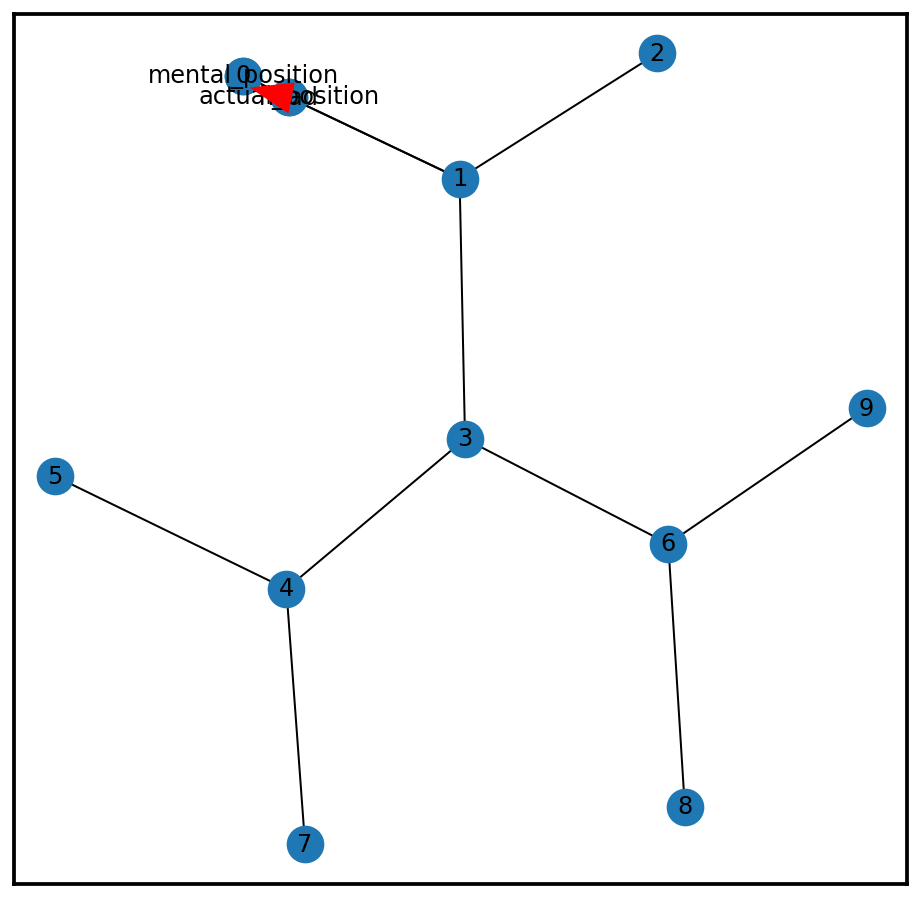

In [689]:
time_ind = 1
actual_pos = actual_projected_position[time_ind]
head_direction = angle[time_ind]
mental_pos = copy_graph.nodes[0]["pos"]
mental_edge = [0, 1]

copy_graph = track_graph.copy()
copy_graph.add_node("actual_position", pos=actual_pos)
copy_graph.add_node("head", pos=actual_pos)
copy_graph.add_node("mental_position", pos=mental_pos)

node_ahead = points_toward_node(copy_graph, actual_edge, head_direction)
node_behind = actual_edge[~np.isin(actual_edge, node_ahead)][0]

if np.all(actual_edge == mental_edge):
    same_side = get_distance_between_nodes(
        copy_graph, "actual_position", "mental_position"
    ) <= get_distance_between_nodes(copy_graph, "actual_position", "node_ahead")
    if same_side:
        node_order = [
            node_ahead,
            "mental_position",
            "head",
            "actual_position",
            node_behind,
        ]
    else:
        node_order = [
            node_ahead,
            "head",
            "actual_position",
            "mental_position",
            node_behind,
        ]
else:
    node_order = [node_ahead, "head", "actual_position", node_behind]


for node1, node2 in zip(node_order[:-1], node_order[1:]):
    distance = get_distance_between_nodes(copy_graph, node1, node2)
    copy_graph.add_edge(node1, node2, distance=distance)

path = nx.shortest_path(
        copy_graph,
        source="actual_position",
        target="mental_position",
        weight="distance",
    )  
    
    
fig, ax = plt.subplots(figsize=(8, 8))
node_position = nx.get_node_attributes(copy_graph, "pos")
nx.draw_networkx(copy_graph, node_position, ax)
plt.arrow(
    actual_pos[0],
    actual_pos[1],
    1e-5 * np.cos(angle[time_ind]),
    1e-5 * np.sin(angle[time_ind]),
    zorder=1000,
    head_width=1.5,
    linewidth=3,
    color="red",
)
path 

print(
    1 if "head" in path else -1,
)
copy_graph.remove_node("actual_position")
copy_graph.remove_node("head")
copy_graph.remove_node("mental_position")

In [691]:
def get_ahead_or_behind(
    track_graph, actual_pos, actual_edge, head_direction, mental_pos, mental_edge
):
    """

    Parameters
    ----------
    track_graph : nx.Graph
    actual_pos : array-like, shape (2,)
    mental_pos : array-like, shape (2,)

    Returns
    -------
    ahead_behind : {-1, 0, 1}
        -1 is behind, 1 is ahead, 0 is same

    """
    if np.allclose(actual_pos, mental_pos):
        return 0
    else:
        track_graph.add_node("actual_position", pos=actual_pos)
        track_graph.add_node("head", pos=actual_pos)
        track_graph.add_node("mental_position", pos=mental_pos)

        # determine which node head is pointing towards
        node_ahead = points_toward_node(
            track_graph, actual_edge, head_direction)
        node_behind = actual_edge[~np.isin(actual_edge, node_ahead)][0]

        # insert edges between nodes
        if np.all(actual_edge == mental_edge):  # if all on same edge
            same_side = (
                get_distance_between_nodes(track_graph, "actual_position", "mental_position") <=
                get_distance_between_nodes(track_graph, "actual_position", node_ahead))
            if same_side:
                node_order = [
                    node_ahead,
                    "mental_position",
                    "head",
                    "actual_position",
                    node_behind,
                ]
            else:
                node_order = [
                    node_ahead,
                    "head",
                    "actual_position",
                    "mental_position",
                    node_behind,
                ]
        else:
            node_order = [node_ahead, "head", "actual_position", node_behind]

        for node1, node2 in zip(node_order[:-1], node_order[1:]):
            distance = get_distance_between_nodes(track_graph, node1, node2)
            track_graph.add_edge(node1, node2, distance=distance)

        # Find shortest path in terms of nodes
        path = nx.shortest_path(
            track_graph,
            source="actual_position",
            target="mental_position",
            weight="distance",
        )

        # Cleanup: remove inserted nodes
        track_graph.remove_node("actual_position")
        track_graph.remove_node("head")
        track_graph.remove_node("mental_position")

        return 1 if "head" in path else -1